# Install the necessary packages

In [9]:
# Load libraries:
library(tidyverse) # metapackage of all tidyverse packages
library(jsonlite) # - jsonlite: stream large, line-delimited JSON files
library(tidyr) # - tidyr:    unnest/flatten list-columns
library(purrr) # - purrr:    map() to normalize NULLs in list-columns

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
# Read the Yelp business JSON file efficiently
business_df <- jsonlite::stream_in(
  # Open the file from the Kaggle input folder
  file("/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json"),
  
  # Flatten nested fields (like attributes and hours) into normal columns
  flatten = TRUE
)

# Result: 'business_df' is a tidy data frame with all business info in flat columns


opening file input connection.



 Imported 150346 records. Simplifying...


closing file input connection.



# Understanding the Structure of the Data

In [10]:
# Check structure
glimpse(business_df)

Rows: 150,346
Columns: 58
$ business_id                           <chr> "Pns2l4eNsfO8kk83dixA6A", "mpf3x…
$ name                                  <chr> "Abby Rappoport, LAC, CMQ", "The…
$ address                               <chr> "1616 Chapala St, Ste 2", "87 Gr…
$ city                                  <chr> "Santa Barbara", "Affton", "Tucs…
$ state                                 <chr> "CA", "MO", "AZ", "PA", "PA", "T…
$ postal_code                           <chr> "93101", "63123", "85711", "1910…
$ latitude                              <dbl> 34.42668, 38.55113, 32.22324, 39…
$ longitude                             <dbl> -119.71120, -90.33570, -110.8804…
$ stars                                 <dbl> 5.0, 3.0, 3.5, 4.0, 4.5, 2.0, 2.…
$ review_count                          <int> 7, 15, 22, 80, 13, 6, 13, 5, 19,…
$ is_open                               <int> 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,…
$ categories                            <chr> "Doctors, Traditional Chinese Me…
$ attributes.B

# Selecting And Examining Column Data Types

* Let's examine the structure of certain columns
* We will ignore anything with "hours" or "attribute" it's the name

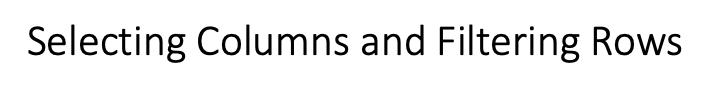
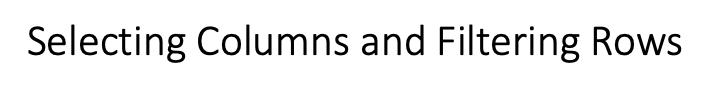
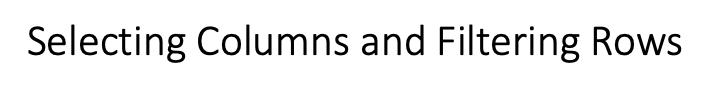
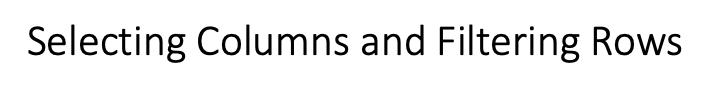
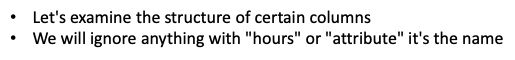
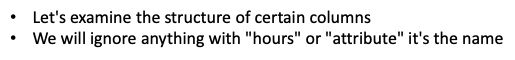
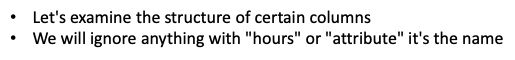
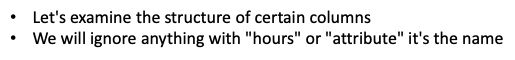
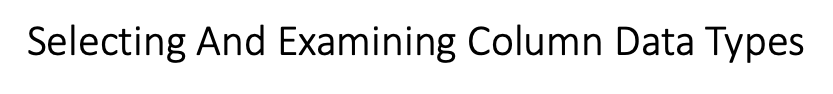
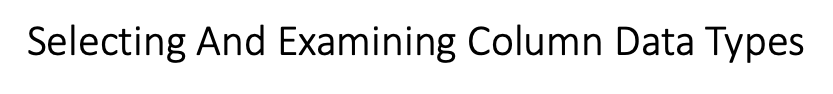
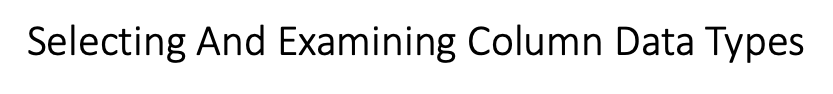
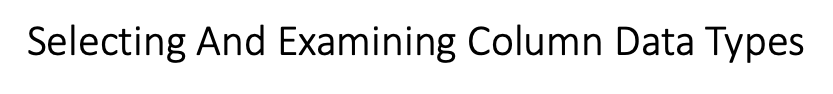

In [11]:
# Select all columns except those starting with "hours" or "attribute"
business_df %>%
  select(-starts_with("hours"), -starts_with("attribute")) %>%  # Remove all columns that start with "hours" or "attribute"
  head(5)   # Display the first 5 rows


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
1,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.42668,-119.71120,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists"
2,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.55113,-90.33570,3.0,15,1,"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services"
3,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.22324,-110.88045,3.5,22,0,"Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores"
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.95551,-75.15556,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries"
5,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.33818,-75.47166,4.5,13,1,"Brewpubs, Breweries, Food"


# Filtering Rows
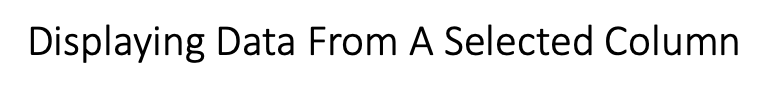
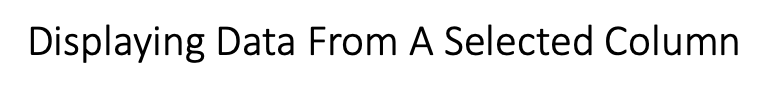
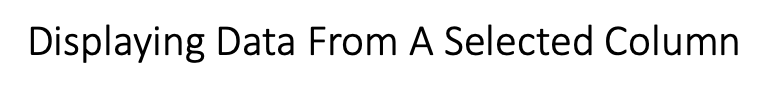
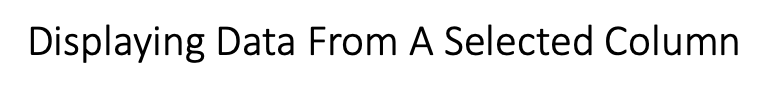

In [12]:
# Select and filter restaurant data
business_df %>%
  select(categories) %>%                           # Keep only the 'categories' column
  filter(str_detect(categories, "Restaurant"))%>%  # Filter rows containing the word "Restaurant"
    head (5)


,categories
,<chr>
1,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries"
2,"Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants"
3,"Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek"
4,"Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food"
5,"Vietnamese, Food, Restaurants, Food Trucks"


# Splitting, Mutating And Unnesting
* Separate the the elements in the the categories column at the delimiter(,)
* Place each element onto a separate row
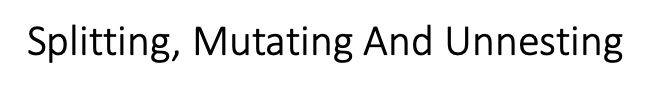
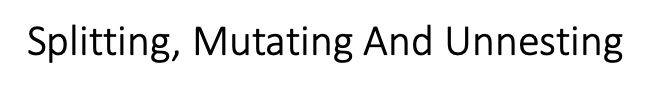
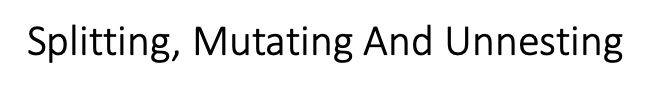
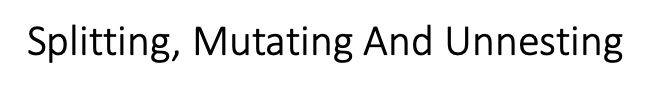
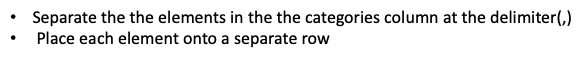
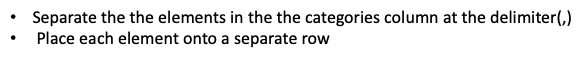
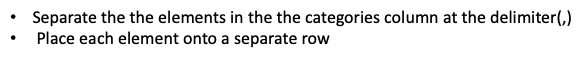
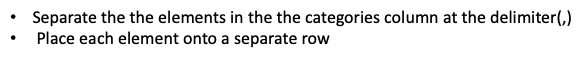

In [13]:
# Filter and expand restaurant categories
business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%         # Keep only rows where 'categories' contains "Restaurant"
  mutate(categories_new = strsplit(categories, ",")) %>%   # Split the 'categories' column into a list using commas as separators
  unnest(categories_new) %>%                               # Expand the list so each category appears in its own row
  select(name, categories_new) %>%                         # Keep only business name and category columns
    head (5)



name,categories_new
<chr>,<chr>
St Honore Pastries,Restaurants
St Honore Pastries,Food
St Honore Pastries,Bubble Tea
St Honore Pastries,Coffee & Tea
St Honore Pastries,Bakeries


# Remove Unnecessary Spaces
* Ultimately, we would like to group and count the number of different categories associated with restaurants.
* Notice that there is a space before some of the elements in the categories column  
* This may be problematic when we group and count the observations.
* Let's remove all unnecessary spaces
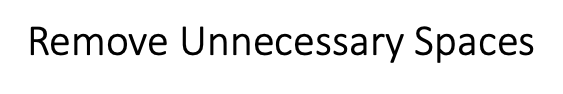
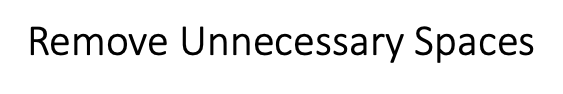
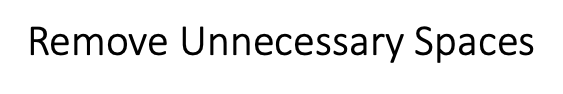
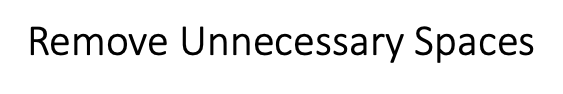
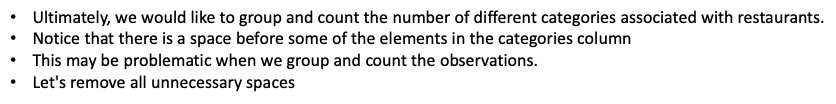
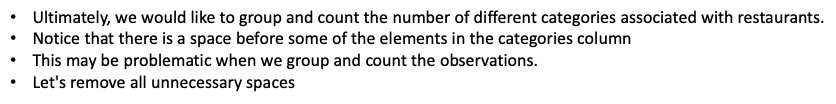
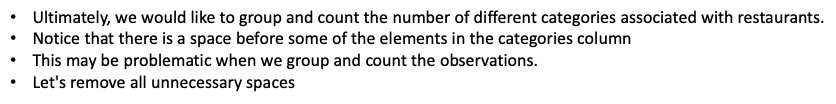
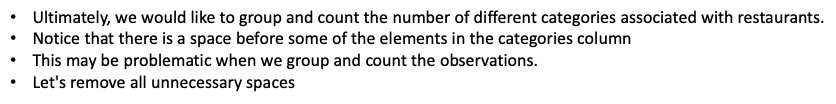

In [14]:
# Filter, split, clean, and preview restaurant categories
business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%                   # Keep only restaurant rows
  mutate(categories_new = strsplit(categories, ",")) %>%             # Split categories by comma
  unnest(categories_new) %>%                                         # Expand each category to its own row
  select(name, categories_new) %>%                                   # Keep name and category
  mutate(categories_new = str_trim(str_squish(categories_new))) %>%  # Remove extra spaces
  head(5)                                                            # Show first 5 rows


name,categories_new
<chr>,<chr>
St Honore Pastries,Restaurants
St Honore Pastries,Food
St Honore Pastries,Bubble Tea
St Honore Pastries,Coffee & Tea
St Honore Pastries,Bakeries


# Remove Unnecessary Spaces: Alternative Approach
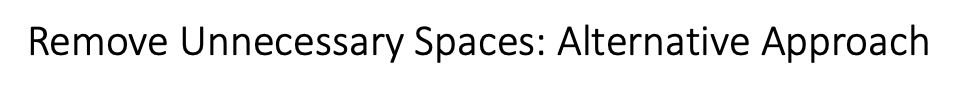
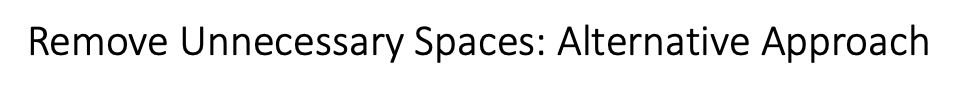
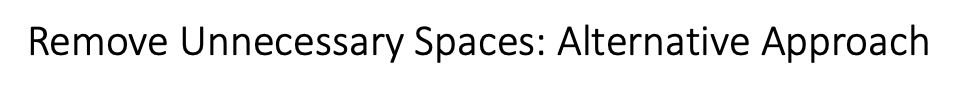
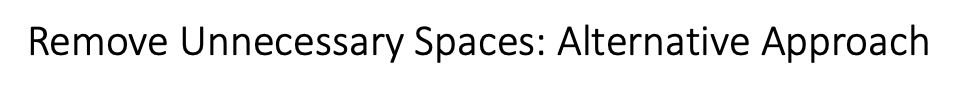

In [15]:
# Filter, clean, and preview restaurant categories
business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%                   # Keep only restaurant rows
  mutate(categories_new = strsplit(categories, ",")) %>%             # Split multiple categories by comma
  unnest(categories_new) %>%                                         # Expand each category into its own row
  select(name, categories_new) %>%                                   # Keep business name and category
  mutate(categories_new = str_trim(str_squish(categories_new))) %>%  # Remove extra spaces
  head(5)                                                            # Show first 5 results


name,categories_new
<chr>,<chr>
St Honore Pastries,Restaurants
St Honore Pastries,Food
St Honore Pastries,Bubble Tea
St Honore Pastries,Coffee & Tea
St Honore Pastries,Bakeries


# Count and Sort
* Count the number of different categories associated with restaurants and sort them them from most to least

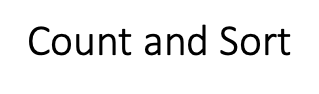
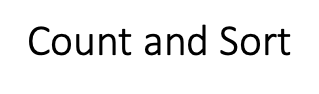
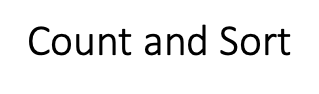
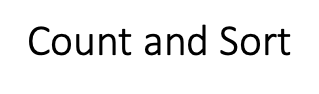
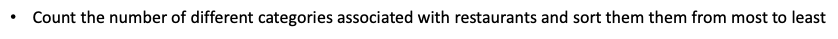
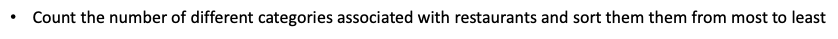
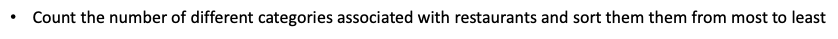
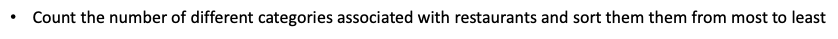

In [16]:
# Filter, clean, count, and sort restaurant categories
business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%            # Keep only rows with 'Restaurant'
  mutate(categories_new = strsplit(categories, ",")) %>%      # Split categories into lists
  unnest(categories_new) %>%                                  # Expand each category into its own row
  select(name, categories_new) %>%                            # Keep business name and category
  mutate(categories_new = str_trim(str_squish(categories_new))) %>%  # Clean up spaces
  count(categories_new) %>%                                   # Count how often each category appears
  arrange(desc(n))                                            # Sort by most common categories


categories_new,n
<chr>,<int>
Restaurants,52268
Food,15477
Nightlife,8723
Sandwiches,8366
Bars,8337
American (Traditional),8139
Pizza,7093
Fast Food,6472
Breakfast & Brunch,6239


# Filter
* Let's see which are the most popular types of categories in each state or province
* We will filter out the words "Restaurant" and "Food" since those are likely to be common for all the establishments

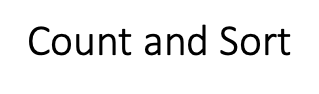
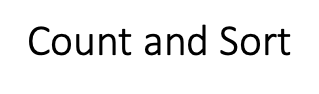
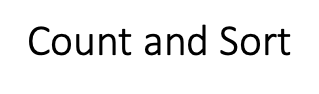
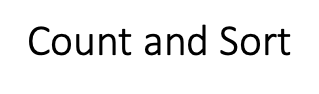
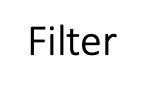
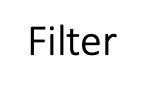
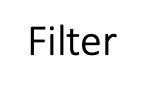
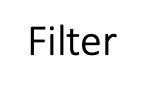
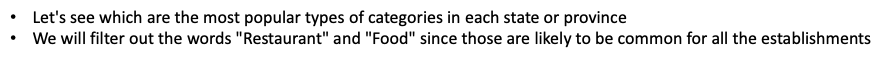
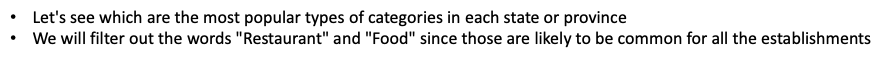
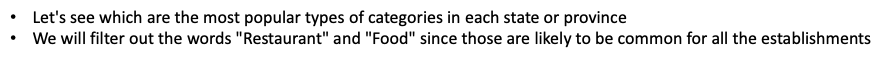
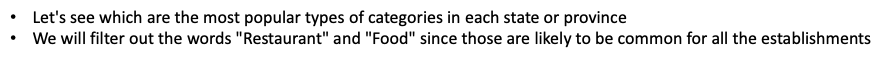

In [17]:
# Clean, filter, and count restaurant categories
print(business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%             # Keep only restaurant rows
  mutate(categories_new = strsplit(categories, ",")) %>%       # Split multiple categories
  unnest(categories_new) %>%                                   # Expand each category into its own row
  select(name, categories_new) %>%                             # Keep name and category columns
  mutate(categories_new = str_trim(str_squish(categories_new))) %>%  # Remove extra spaces
  filter(!categories_new %in% c("Restaurants", "Food")) %>%    # Exclude generic labels
  count(categories_new) %>%                                    # Count how often each category appears
  arrange(desc(n)))                                            # Sort by most frequent categories


# A tibble: 728 × 2
   categories_new             n
   <chr>                  <int>
 1 Nightlife               8723
 2 Sandwiches              8366
 3 Bars                    8337
 4 American (Traditional)  8139
 5 Pizza                   7093
 6 Fast Food               6472
 7 Breakfast & Brunch      6239
 8 American (New)          6097
 9 Burgers                 5636
10 Mexican                 4600
# ℹ 718 more rows


# Data Analysis
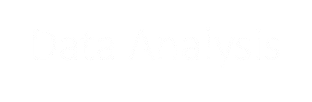
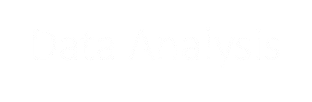
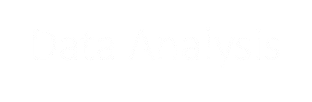
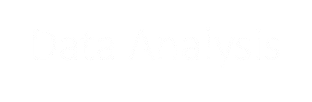

1. Show the number of Different categories besides Restaurants and Food, in each state/province?

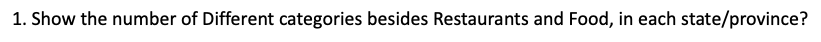
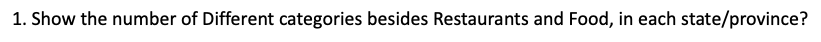
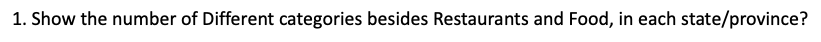
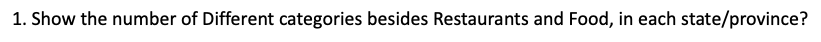

In [18]:
# 1. Show the number of different categories besides Restaurants and Food, in each state/province

business_df %>%
  mutate(categories = strsplit(categories, ",")) %>%
  unnest(categories) %>%
  select(state, categories) %>%
  mutate(categories = str_trim(str_squish(categories))) %>%
  filter(!(categories %in% c("Restaurants", "Food"))) %>%  ## Filter out multiple categories
  group_by(state, categories) %>%
  count(categories) %>%
  arrange(state, desc(n))


state,categories,n
<chr>,<chr>,<int>
AB,Shopping,1042
AB,Beauty & Spas,513
AB,Nightlife,508
AB,Bars,452
AB,Coffee & Tea,378
AB,Fashion,334
AB,Fast Food,321
AB,Pizza,313
AB,Automotive,279


2. How many establishments are there in each state that have the word “Restaurants” as one of their categories
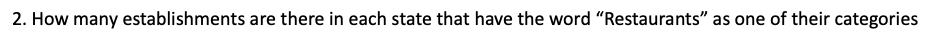
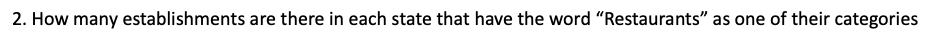
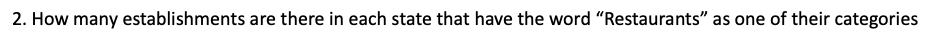
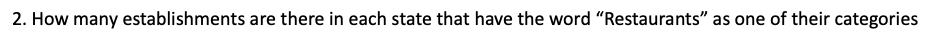

In [21]:
business_df %>%
  mutate(categories = strsplit(categories, ",")) %>%
  unnest(categories) %>%
  select(state, categories) %>%
  mutate(categories = str_trim(str_squish(categories))) %>%
  filter(categories == "Restaurants") %>%  ## Filter out non-restaurants
  group_by(state, categories) %>%
  count(categories) %>%
  arrange(desc(n))


state,categories,n
<chr>,<chr>,<int>
PA,Restaurants,12641
FL,Restaurants,8731
TN,Restaurants,4352
MO,Restaurants,4247
IN,Restaurants,4150
LA,Restaurants,3640
NJ,Restaurants,3341
AZ,Restaurants,2671
AB,Restaurants,2410


3. How many records are there for each state?


In [22]:
business_df %>%
  select(state) %>%
  group_by(state) %>%
  count(state) %>%
  arrange(desc(n))


state,n
<chr>,<int>
PA,34039
FL,26330
TN,12056
IN,11247
MO,10913
LA,9924
AZ,9912
NJ,8536
NV,7715


4. How many establishments are open

In [23]:
business_df %>%
  select(is_open) %>%
  count(is_open) %>%
  arrange(desc(n))


is_open,n
<int>,<int>
1,119698
0,30648


5. How many establishments are open in each state. Sort ascending by state and whether or not they are open.


In [24]:
business_df %>%
  select(state, is_open) %>%
  count(state, is_open) %>%
  arrange(state, desc(is_open))


state,is_open,n
<chr>,<int>,<int>
AB,1,4346
AB,0,1227
AZ,1,8108
AZ,0,1804
CA,1,4065
CA,0,1138
CO,1,1
CO,0,2
DE,1,1894


6. Show the top 10 states in terms of median star review scores. 
Do not include the state XWY. Organize the star ratings in descending order.


In [25]:
business_df %>%
  filter(state != "XWY") %>%
  type_convert(cols(stars = col_double())) %>%  ## Make sure that your star ratings are converted to a double
  select(state, stars) %>%
  group_by(state) %>%
  summarize(Stars = median(stars)) %>%
  arrange(desc(Stars)) %>%
  head(10)


state,Stars
<chr>,<dbl>
MT,5.00
SD,4.50
UT,4.50
VT,4.50
HI,4.25
CA,4.00
CO,4.00
FL,4.00
ID,4.00


7. Show the bottom 5 states in terms of median star review scores. 
Also show the total number of review scores that they have received

In [27]:
business_df %>%
  filter(state != "XWY") %>%
  type_convert(cols(stars = col_double())) %>%
  select(state, review_count, stars) %>%
  group_by(state) %>%
  summarize(Median_Stars = median(stars),
            Number_of_Reviews = sum(review_count)) %>%
  arrange(Median_Stars) %>%
  head(5)


state,Median_Stars,Number_of_Reviews
<chr>,<dbl>,<int>
MA,1.25,43
NC,2.00,29
MI,2.50,9
TX,2.50,33
VI,2.50,10


**Read the Yelp reviews JSON file**

In [28]:
reviews_df <- jsonlite::stream_in(
  # Open the file from the Kaggle input folder
  file("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json"),
 )

opening file input connection.



 Imported 6990280 records. Simplifying...


closing file input connection.



8. Show the establishment with the most 5 star reviews (top 5)


In [29]:
# To answer this question we need to join the business and reviews tables, 
# then count the number of 5 star reviews for each business.

glimpse(business_df)
glimpse(reviews_df)

Rows: 150,346
Columns: 58
$ business_id                           <chr> "Pns2l4eNsfO8kk83dixA6A", "mpf3x…
$ name                                  <chr> "Abby Rappoport, LAC, CMQ", "The…
$ address                               <chr> "1616 Chapala St, Ste 2", "87 Gr…
$ city                                  <chr> "Santa Barbara", "Affton", "Tucs…
$ state                                 <chr> "CA", "MO", "AZ", "PA", "PA", "T…
$ postal_code                           <chr> "93101", "63123", "85711", "1910…
$ latitude                              <dbl> 34.42668, 38.55113, 32.22324, 39…
$ longitude                             <dbl> -119.71120, -90.33570, -110.8804…
$ stars                                 <dbl> 5.0, 3.0, 3.5, 4.0, 4.5, 2.0, 2.…
$ review_count                          <int> 7, 15, 22, 80, 13, 6, 13, 5, 19,…
$ is_open                               <int> 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,…
$ categories                            <chr> "Doctors, Traditional Chinese Me…
$ attributes.B

9. Join the tables by business_id

In [30]:
business_reviews <- business_df %>%
  left_join(reviews_df, by = "business_id")


In [31]:
# Look at the structure of the merged table.
# Note that the columns we need are business_id, name, stars.y
glimpse(business_reviews)


Rows: 6,990,280
Columns: 66
$ business_id                           <chr> "Pns2l4eNsfO8kk83dixA6A", "Pns2l…
$ name                                  <chr> "Abby Rappoport, LAC, CMQ", "Abb…
$ address                               <chr> "1616 Chapala St, Ste 2", "1616 …
$ city                                  <chr> "Santa Barbara", "Santa Barbara"…
$ state                                 <chr> "CA", "CA", "CA", "CA", "CA", "C…
$ postal_code                           <chr> "93101", "93101", "93101", "9310…
$ latitude                              <dbl> 34.42668, 34.42668, 34.42668, 34…
$ longitude                             <dbl> -119.7112, -119.7112, -119.7112,…
$ stars.x                               <dbl> 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.…
$ review_count                          <int> 7, 7, 7, 7, 7, 7, 7, 15, 15, 15,…
$ is_open                               <int> 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,…
$ categories                            <chr> "Doctors, Traditional Chinese Me…
$ attributes

10. Show the establishments with the most number of 5-star reviews (top 5)


In [32]:

business_reviews %>%
  filter(stars.y == 5) %>%                      # Keep only 5-star reviews
  group_by(business_id, name) %>%               # Group by business ID and name
  summarise(Five_Star_Reviews = n()) %>%        # Count number of 5-star reviews
  arrange(desc(Five_Star_Reviews)) %>%          # Sort from most to least
  head(5)                                       # Display top 5 establishments


`summarise()` has grouped output by 'business_id'. You can override using the
`.groups` argument.


business_id,name,Five_Star_Reviews
<chr>,<chr>,<int>
ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,4014
ac1AeYqs8Z4_e2X5M3if2A,Oceana Grill,4012
GXFMD0Z4jEVZBCsbPf4CTQ,Hattie B’s Hot Chicken - Nashville,3838
_ab50qdWOk0DdB6XOrBitw,Acme Oyster House,3645
_C7QiQQc47AOEv4PE3Kong,Commander's Palace,3095


11. Which 5 businesses appear the most times in the dataset

In [34]:
# Order the businesses by how many times they appear

business_reviews %>%
  group_by(name) %>%          # Group data by business name
  summarise(Count = n()) %>%  # Count how many times each name appears
  arrange(desc(Count)) %>%    # Sort from highest to lowest count
  head(5)                     # Show the top 5 most frequent businesses


name,Count
<chr>,<int>
Starbucks,21575
McDonald's,18210
Dunkin',10312
Chipotle Mexican Grill,9763
First Watch,9317


12. Show the number of Starbucks in each state


In [35]:
business_reviews %>%
  filter(name == "Starbucks") %>%     # Keep only rows where the business name is "Starbucks"
  group_by(state) %>%                 # Group data by state
  summarise(Count = n()) %>%          # Count how many Starbucks locations per state
  arrange(desc(Count))                # Sort results from most to fewest


state,Count
<chr>,<int>
PA,4052
FL,3763
IN,2249
NV,1833
TN,1757
MO,1722
AZ,1675
LA,1302
CA,970


13. What percentage of Starbucks 'useful' scores are blank?

In [36]:
business_reviews %>%
  filter(name == "Starbucks") %>%                  # Keep only Starbucks reviews
  group_by(useful) %>%                             # Group by the 'useful' score
  summarise(Count = n()) %>%                       # Count how many of each score
  arrange(desc(Count)) %>%                         # Sort from most to fewest
  mutate(Percentage = round(Count / sum(Count) * 100, 2)) %>%  # Calculate % of each group
  arrange(desc(useful))                            # Order by useful score


useful,Count,Percentage
<int>,<int>,<dbl>
112,1,0.00
108,1,0.00
103,1,0.00
96,1,0.00
70,1,0.00
55,1,0.00
54,2,0.01
47,1,0.00
45,3,0.01


14. Show the proportion of visitors to Yelp's site who rated Starbucks funny reviews 6–11


In [37]:
business_reviews %>%
  filter(name == "Starbucks") %>%                   # Keep only Starbucks reviews
  group_by(funny) %>%                               # Group by the 'funny' rating
  summarise(Count = n()) %>%                        # Count how many of each rating
  arrange(desc(Count)) %>%                          # Sort by most frequent ratings
  mutate(Percentage = round(Count / sum(Count) * 100, 2)) %>%  # Calculate % of each rating
  filter(funny > 5 & funny < 12) %>%                # Keep ratings between 6 and 11
  arrange(desc(funny))                              # Order by rating descending


funny,Count,Percentage
<int>,<int>,<dbl>
11,13,0.06
10,12,0.06
9,13,0.06
8,22,0.10
7,30,0.14
6,42,0.19


15. Show the proportion of visitors to Yelp's site who rated the Starbucks 'cool' reviews below 5


In [38]:

business_reviews %>%
  filter(name == "Starbucks") %>%                     # Keep only Starbucks reviews
  group_by(cool) %>%                                 # Group by the 'cool' rating
  summarise(Count = n()) %>%                         # Count how many reviews for each rating
  arrange(desc(Count)) %>%                           # Sort from most to fewest ratings
  mutate(Percentage = round(Count / sum(Count) * 100, 2)) %>%  # Calculate % for each rating
  filter(cool < 5) %>%                               # Keep ratings below 5
  summarise(Freq = sum(Percentage))                  # Sum percentages to get total share below 5


Freq
<dbl>
97.99


16. How many businesses have the same name in the dataset?


In [39]:
# First, determine how many unique business IDs there are
unique_business_ids <- business_df %>%
  distinct(business_id) %>%
  count()

# Next, determine how many unique business names there are
unique_business_names <- business_df %>%
  distinct(name) %>%
  count()

# Find the difference between the unique business IDs and the unique business names
unique_business_ids - unique_business_names


n
<int>
36229


# Test Analysis
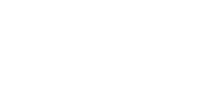
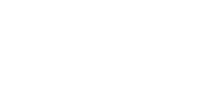
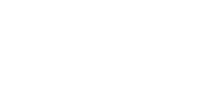
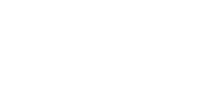

## Sentiment Analysis

Let’s try to gauge the sentiment in the reviews
We will attempt to 
1.  identify the most negative and positive 
2. assign sentiment scores to each review
3. chart the review scores

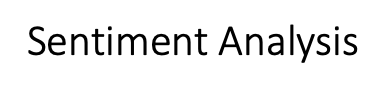
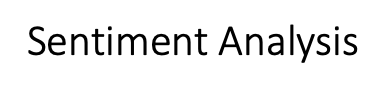
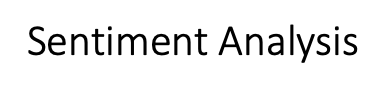
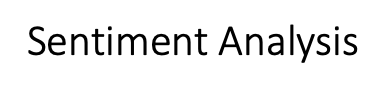
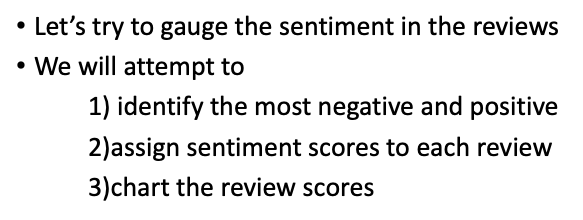
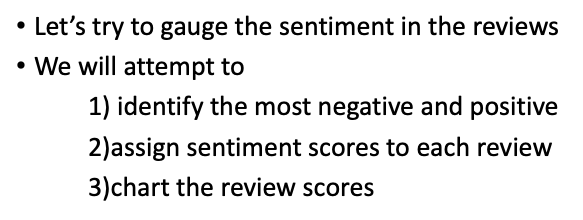
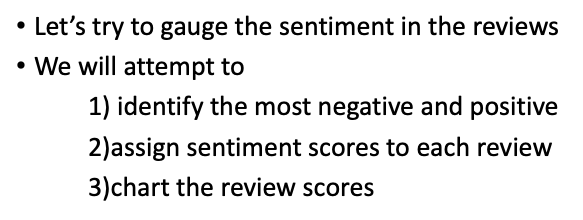
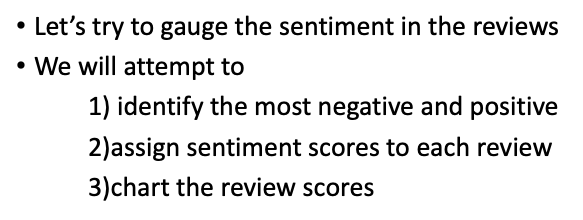

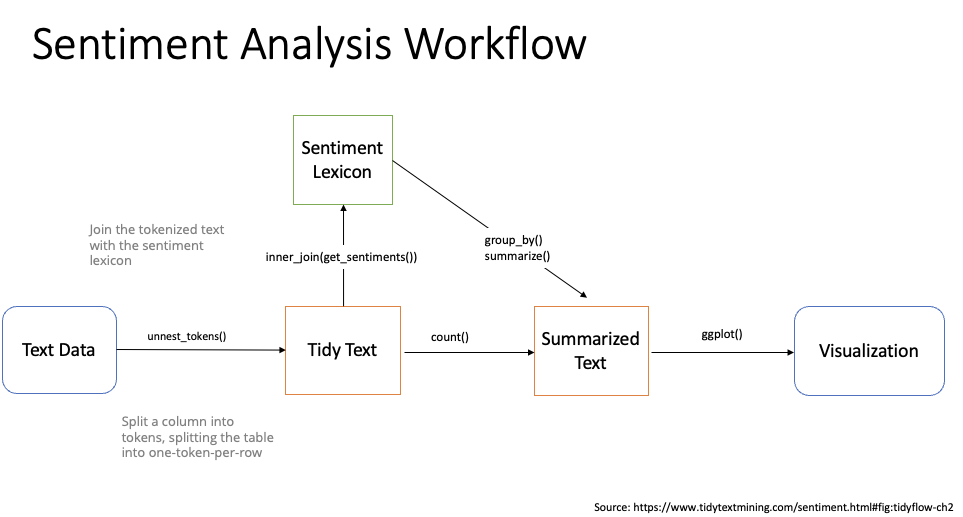


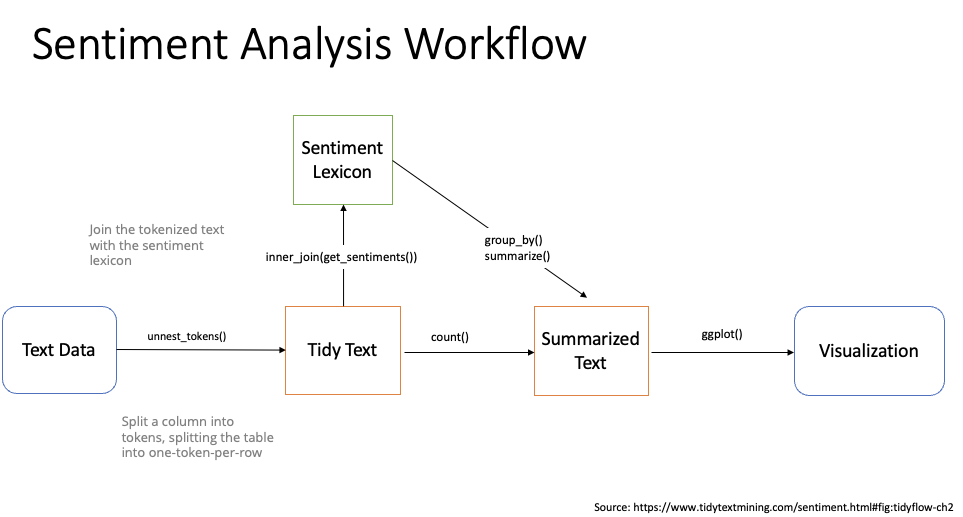
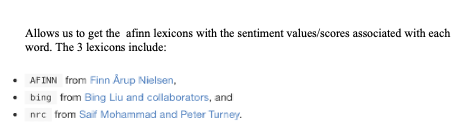

**Install tidytext if not already installed & Load AFINN sentiment lexicon**

In [40]:

# This code ensures the tidytext package is available for text analysis and manually loads the AFINN sentiment lexicon from a CSV file to provide word sentiment scores for analysis.
install.packages("tidytext")
library(tidytext)

# Manually create the AFINN lexicon from a local CSV version
afinn <- read.csv("https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt",
                  sep = "\t", header = FALSE)
colnames(afinn) <- c("word", "value")

head(afinn)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,word,value
,<chr>,<int>
1,abandon,-2
2,abandoned,-2
3,abandons,-2
4,abducted,-2
5,abduction,-2
6,abductions,-2



**Let's only analyze Starbucks reviews**

In [41]:

starbucks_reviews <- business_reviews %>%
  filter(name == "Starbucks")


**Calculate Sentiment Score**

A sentiment score is a numerical value that represents the emotional tone of a piece of text — showing whether it’s positive, negative, or neutral.

In [56]:
# Calculate average sentiment score for each Starbucks review
customer_sentiment <- starbucks_reviews %>%
  unnest_tokens(word, text) %>%          # Split review text into individual words
  inner_join(afinn, by = "word") %>%     # Add sentiment scores from AFINN lexicon
  group_by(review_id) %>%                # Group words by each review
  summarize(sentiment = mean(value),     # Average sentiment score per review
            words = n()) %>%             # Count words in each review
  ungroup() %>%                          # Remove grouping
  filter(words >= 5)                     # Keep reviews with 5+ words

# View the resulting sentiment data
customer_sentiment





review_id,sentiment,words
<chr>,<dbl>,<int>
--NvmYEwvxTztmaOMg-CTQ,-1.1428571,7
--WE5ZxJw93FTIQhmkhGkg,1.6000000,5
--flZJ-AFYt2nmt3YiJ8QA,-1.2857143,7
-0GP2K35-fQh-leBIQKqNA,-0.8000000,5
-0qGGbhTc-yC6_oVoAWl4g,2.4000000,5
-1MRn2RfsNIngZ0m3b9bDQ,0.1428571,7
-1dotHJyQaEMIacS_DQgLw,-1.2000000,15
-2Q38sdYCv61LT7zcDkcLA,1.7368421,19
-2Tfb3-i1pWnlnuEBUnJdw,-1.8000000,5


**Find the 10 most negative Starbucks reviews**

In [43]:
customer_sentiment %>%
  arrange(sentiment) %>%                     # Sort reviews from most negative to most positive
  top_n(-10, sentiment) %>%                  # Select the 10 lowest sentiment scores (most negative)
  inner_join(starbucks_reviews, by = "review_id") %>%  # Add review details (address, city, date, text)
  select(address, city, date, sentiment, text)          # Keep only relevant columns for display



address,city,date,sentiment,text
<chr>,<chr>,<chr>,<dbl>,<chr>
200 Washington Square W,Philadelphia,2015-11-28 22:03:47,-3.000000,Yooooo WTF!!!! Yoooo how's that even possible! Yooooo! They have only one background music and yooooo it's so terrible! Yooooooo! I stayed here for 30 minutes! Yoooo that stupid song is driving me crazy yoooo! WTF
7555 N La Cholla Blvd,Tucson,2021-01-13 19:37:37,-2.800000,"they don't even deserve 1 star. this is the worst place ever. the workers are rude. constantly have attitudes. never listen to you or your order. they never let the drive through know that they are closed and there's always cars lined up to the rode waiting, little do they know the store is closed. this starbucks makes me angry every time i go and it honestly just makes me so angry at how dis organized they are and how non communicated they are with their customers. worst starbucks ever.!!!!!!"
203 East Speedway Blvd,Tucson,2020-09-07 19:44:31,-2.800000,I wait in the line 32 minutes to get my order and when I order they told me everything I order they told me they didn't have it and also all the time Different price they charge me and also they are fucking so mean and when they give me my Order all of it ice that is fucked up really fucked up and also the fucking drink it's just like a water taste
2835 N McCarren Blvd,Sparks,2016-05-15 03:03:30,-2.714286,"Okay very upset that I have to write a bad review. The lady who was at the window 'preeti' is her name. She was extremely unprofessional and damn right rude!! 1st seems pissed off by just seeing my face,doesn't give me a receipt, and as I'm waiting to ask her for it she rolls her eyes at me,so that pissed me off so I wait to tell her to be a little more respectful to customers and she closed the window on me while I was talking! !!!!!!!!!!! Corporate will hear from me if her boss doesn't do something about this."
407 N Virginia St,Reno,2018-09-24 00:25:20,-2.714286,"KYLIE HAS TERRIBLE CUSTOMER SERVICE SKILLS AND A VERY NASTY ATTITUDE. The ladies that work their are very rude. Insulted me on my vacation. And my coffee and food was very cold and nasty. If you hate your life because you work at Starbucks then quit, don't take it out on the customers. WORST Starbucks i have ever been too."
1001-1005 Chestnut St,Philadelphia,2018-01-31 22:16:41,-2.666667,"Gross!! Toilet is fucking disgusting,one homeless woman taking over the condiment station eating and drinking her coffee and looking in the trash and another one talking to him Self in the seating area. No place to sit and it's freezing outside and I just paid $5 for coffee. FUCK this place"
"50 South Houghton Rd, Ste 126",Tucson,2016-07-27 08:49:18,-2.666667,"Kleine Starbucks Filiale. Nichts Besonderes, leider gibt es nur 2 bequeme Sessel, ansonsten nur harte Holzstühle. Die Bedienung war nett (was bei Starbucks nicht immer der Fall ist). Die Getränke schmeckten wie überall, was die Sache sehr angenehm macht. Man weiß, was man bekommt. Meine Gattin hatte Strawberry Smoothie, die Kids den ""Very Berry Hibiscus"" und ich, wie fast immer, den Venti Latte. Ich habe bei allen probiert :-), alles war sehr lecker."
6363 Saint Charles Ave,New Orleans,2018-09-05 15:22:58,-2.600000,"I absolutely hate going to this Starbucks, but I go occasionally because it's on my university campus. It is literally awful. The line is always very long. Then, when you get to the register they are ALWAYS out of everything. The staff is so rude!!! Today when I went, they were out of all alternative options of milk, which I am allergic to. They did not have almond, coconut or soy milk. This is a terrible place!!!!!!!!!!!!!!!!!"
5220 Little Rd,New Port Richey,2015-09-28 16:22:48,-2.600000,"As a Starbucks partner myself I expect to be treated exactly how we are trained to treat our customers when I go to a store. This Starbucks has the worst customer service I've seen in any Starbucks. I went through the drive thru. My order was rushed, put in incorrectly and misun

**Find the 10 most positive Starbucks reviews**

In [44]:
customer_sentiment %>%
  arrange(desc(sentiment)) %>%                  # Sort reviews from most positive to most negative
  top_n(10, sentiment) %>%                      # Select the top 10 highest sentiment scores
  inner_join(starbucks_reviews, by = "review_id") %>%  # Add review details (address, city, date, text)
  select(address, city, date, sentiment, text)          # Keep only relevant columns for display



address,city,date,sentiment,text
<chr>,<chr>,<chr>,<dbl>,<chr>
6291 E Speedway Blvd,Tucson,2013-11-08 17:06:06,3.400000,Stuff is awesome the service is fast and amazing. This Starbucks is always busy but you never wait to long. Starbucks coffee is a little over priced but once in a while its good. Love the holiday flavors. Pumpkin spice one of the best of all times.
"9525 E Old Spanish Trl, Ste 113",Tucson,2016-08-08 16:35:09,3.400000,Love this Starbucks. Excellent customer service. Lawson is the manager and has such an awesome staff. I come here on a daily basis because of the atmosphere and awesome customer service I get. They have plenty of seating both inside and out. I come here to drink my coffee and relax. Love this place.
330 S Virginia St,Reno,2019-02-22 23:25:01,3.400000,I think this is honestly one of the best Starbucks in town and I don't say that because it's next to where I work. The service is always great even when they're in the middle of a rush. I have always had great tasting drinks and awesome recommendations by the baristas. Keep up the awesome work guys!
10002 N Dale Mabry Hwy,Tampa,2019-02-10 00:12:34,3.400000,Wow this place is huuuge! Very nice chill spot. Loved it and need to find a reason to go out of my way to go there. The drink i had was amazing. People were nice too
"6970 E 22nd St, Ste 112",Tucson,2019-07-03 14:14:33,3.333333,"This location (22nd and Kolb) has hands down had the best service each and every time! They are consistent with their great team work, superb customer service and awesome quality/speed of the menu items. My Momma raves about this location and the few times I've been here, they have lived up to her praises!"
1199 Terry Pkwy,Gretna,2017-11-07 20:16:08,3.250000,"The partners out here are super great! my family is visiting from California! I just so happen to be a partner from California. The partners out here are amazing and I love the fact that this Starbucks happens to be around the corner from where I stay!! Nelly Nel was the first to show that good old Louisiana southern hospitality, Mo and Sarah were awesome as well! Thank you guys for making my experince here an fantastic one!!! #tobeapartner!!!"
204 S Royal Oaks Blvd,Franklin,2015-05-23 19:00:21,3.200000,Consistently good drinks and all the people working there are super nice and awesome. It can get busy at times but that's just because SB is great :)
"2401 East Bay Dr, Ste 1",Largo,2020-08-10 14:23:26,3.200000,"I come to this Starbucks a lot. But this morning the person at the window made my day extra fabulous!!! They had black and red hair, they were super nice and made me feel so good!! I didn't get to catch their name, but they deserve praise!!"
7373 West Fairview,Boise,2014-03-08 20:50:05,3.200000,Love this particular Starbucks it is much bigger than the other stores in the valley and it is right next to axiom nice to come her in the morning after a workout. Service is always awesome and there are plenty of funny and interesting people! Saul is the nicest guy! He's the Mann!


#  Create a Wordcloud

Here’s a simple 3-step outline of the process to create word clouds based on your code:

1️⃣ Prepare the text data: Extract the desired reviews (e.g., negative ones) and clean them using the tm package — removing numbers, punctuation, extra spaces, and stopwords.

2️⃣ Create a document-term matrix: Convert the cleaned text into a TermDocumentMatrix and compute word frequencies from it.

3️⃣ Generate the word cloud: Use the wordcloud() function with frequencies and visual options (e.g., colors, rotation, max words) to display the most frequent words visually.

In [45]:
# Install Required Packages
install.packages("wordcloud")    # Installs the 'wordcloud' package for visualizing word frequencies
library(wordcloud)               # Loads the 'wordcloud' package

install.packages("RColorBrewer") # Installs 'RColorBrewer' for color palettes used in plots
library(RColorBrewer)            # Loads 'RColorBrewer' package

install.packages("tm")           # Installs the 'tm' package for text mining and cleaning
library(tm)                      # Loads the 'tm' package



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: RColorBrewer

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


The following object is masked from ‘package:httr’:

    content




**Prepare text data: Create a vector containing only the most negative Starbucks reviews**



In [46]:
negative_text <- customer_sentiment %>%
  arrange(sentiment) %>%                        # Sort reviews from most negative to most positive
  top_n(-20, sentiment) %>%                     # Select the 20 most negative reviews
  inner_join(starbucks_reviews, by = "review_id") %>%  # Add the original review details
  select(text)                                  # Keep only the review text column

negative_text                                   # Display the negative review texts



text
<chr>
Yooooo WTF!!!! Yoooo how's that even possible! Yooooo! They have only one background music and yooooo it's so terrible! Yooooooo! I stayed here for 30 minutes! Yoooo that stupid song is driving me crazy yoooo! WTF
"they don't even deserve 1 star. this is the worst place ever. the workers are rude. constantly have attitudes. never listen to you or your order. they never let the drive through know that they are closed and there's always cars lined up to the rode waiting, little do they know the store is closed. this starbucks makes me angry every time i go and it honestly just makes me so angry at how dis organized they are and how non communicated they are with their customers. worst starbucks ever.!!!!!!"
I wait in the line 32 minutes to get my order and when I order they told me everything I order they told me they didn't have it and also all the time Different price they charge me and also they are fucking so mean and when they give me my Order all of it ice that is fucked up really fucked up and also the fucking drink it's just like a water taste
"Okay very upset that I have to write a bad review. The lady who was at the window 'preeti' is her name. She was extremely unprofessional and damn right rude!! 1st seems pissed off by just seeing my face,doesn't give me a receipt, and as I'm waiting to ask her for it she rolls her eyes at me,so that pissed me off so I wait to tell her to be a little more respectful to customers and she closed the window on me while I was talking! !!!!!!!!!!! Corporate will hear from me if her boss doesn't do something about this."
"KYLIE HAS TERRIBLE CUSTOMER SERVICE SKILLS AND A VERY NASTY ATTITUDE. The ladies that work their are very rude. Insulted me on my vacation. And my coffee and food was very cold and nasty. If you hate your life because you work at Starbucks then quit, don't take it out on the customers. WORST Starbucks i have ever been too."
"Gross!! Toilet is fucking disgusting,one homeless woman taking over the condiment station eating and drinking her coffee and looking in the trash and another one talking to him Self in the seating area. No place to sit and it's freezing outside and I just paid $5 for coffee. FUCK this place"
"Kleine Starbucks Filiale. Nichts Besonderes, leider gibt es nur 2 bequeme Sessel, ansonsten nur harte Holzstühle. Die Bedienung war nett (was bei Starbucks nicht immer der Fall ist). Die Getränke schmeckten wie überall, was die Sache sehr angenehm macht. Man weiß, was man bekommt. Meine Gattin hatte Strawberry Smoothie, die Kids den ""Very Berry Hibiscus"" und ich, wie fast immer, den Venti Latte. Ich habe bei allen probiert :-), alles war sehr lecker."
"I absolutely hate going to this Starbucks, but I go occasionally because it's on my university campus. It is literally awful. The line is always very long. Then, when you get to the register they are ALWAYS out of everything. The staff is so rude!!! Today when I went, they were out of all alternative options of milk, which I am allergic to. They did not have almond, coconut or soy milk. This is a terrible place!!!!!!!!!!!!!!!!!"
"As a Starbucks partner myself I expect to be treated exactly how we are trained to treat our customers when I go to a store. This Starbucks has the worst customer service I've seen in any Starbucks. I went through the drive thru. My order was rushed, put in incorrectly and misunderstood. When I got to the window the barista didn't have his name tag on and he was uninterested. I was charged for a drink I didn't receive. The shots were dead. The sandwich's egg was still frozen as well. This store should be ashamed of themselves."


**Prepare text data: Create a corpus that can be cleaned using the 'tm' package**

In [48]:
negative_docs <- Corpus(VectorSource(negative_text))  # Convert the negative reviews into a text corpus



**Prepare text data: Clean Text**

In [49]:
negative_docs <- negative_docs %>%
  tm_map(removeNumbers) %>%            # Remove all numbers
  tm_map(removePunctuation) %>%        # Remove punctuation marks
  tm_map(stripWhitespace)              # Remove extra spaces

negative_docs <- tm_map(negative_docs, content_transformer(tolower))           # Convert all text to lowercase
negative_docs <- tm_map(negative_docs, removeWords, stopwords("english"))      # Remove common English stopwords



Warning message in tm_map.SimpleCorpus(., removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., stripWhitespace):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(negative_docs, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(negative_docs, removeWords, stopwords("english")):
“transformation drops documents”


**Create a document-term matrix: Create a term frequency table showing which words appear most often in your cleaned negative reviews.**

In [50]:
# Create a document-term matrix
dtm <- TermDocumentMatrix(negative_docs)      # Create a matrix of terms (rows) and documents (columns)
matrix <- as.matrix(dtm)                      # Convert the document-term matrix into a standard R matrix
words <- sort(rowSums(matrix), decreasing = TRUE)  # Sum word frequencies and sort them from highest to lowest
words                                          # Display the sorted word frequencies


starbucks          order          worst        service         coffee 
            27             24             15             13             12 
         never           rude          drink            got           told 
            11             10              8              8              8 
     customers           ever           just           wait           went 
             7              7              7              7              7 
          also           even            get        minutes            one 
             6              6              6              6              6 
      terrible           work         always          awful           back 
             6              6              5              5              5 
         didnt           line          place           time            two 
             5              5              5              5              5 
        window     absolutely           busy       customer     experience 
             5              4              4              4              4 
          girl           hand          items         mobile           name 
             4              4              4              4              4 
         nasty         people       register           will       absolute 
             4              4              4              4              3 
           ask          asked            bad        barista        charged 
             3              3              3              3              3 
        closed           cold           crap            cup            day 
             3              3              3              3              3 
           die           dont          drive        fucking            guy 
             3              3              3              3              3 
        handed           hate            ive           know           long 
             3              3              3              3              3 
       mention        ordered          ready           slow          still 
             3              3              3              3              3 
         store        talking           tell        waiting          worse 
             3              3              3              3              3 
         yoooo          ahead          angry        another          bagel 
             3              2              2              2              2 
           bei          blond         called            can           cars 
             2              2              2              2              2 
       company     completely        counter      croissant         danish 
             2              2              2              2              2 
       decided            den         drinks      employees     everything 
             2              2              2              2              2 
         fired          front         fucked           give           hair 
             2              2              2              2              2 
          half           hear           hell       horrible           iced 
             2              2              2              2              2 
         immer          later           less           life         little 
             2              2              2              2              2 
         makes            man        manager           mask           milk 
             2              2              2              2              2 
      multiple            nur       ordering        outside           paid 
             2              2              2              2              2 
        pissed          price      proceeded            put         racist 
             2              2              2              2              2 
          read        receive         review           said           sehr 
             2              2              2              2              2 
          shit          short      something         

**Convert the document-term-matrix to a data frame**


In [51]:
df <- data.frame(word = names(words), freq = words)
df


,word,freq
,<chr>,<dbl>
starbucks,starbucks,27
order,order,24
worst,worst,15
service,service,13
coffee,coffee,12
never,never,11
rude,rude,10
drink,drink,8
got,got,8


**Convert the document-term-matrix to a data frame**


In [52]:
df <- data.frame(word = names(words), freq = words)
df


,word,freq
,<chr>,<dbl>
starbucks,starbucks,27
order,order,24
worst,worst,15
service,service,13
coffee,coffee,12
never,never,11
rude,rude,10
drink,drink,8
got,got,8


**Create a wordcloud**

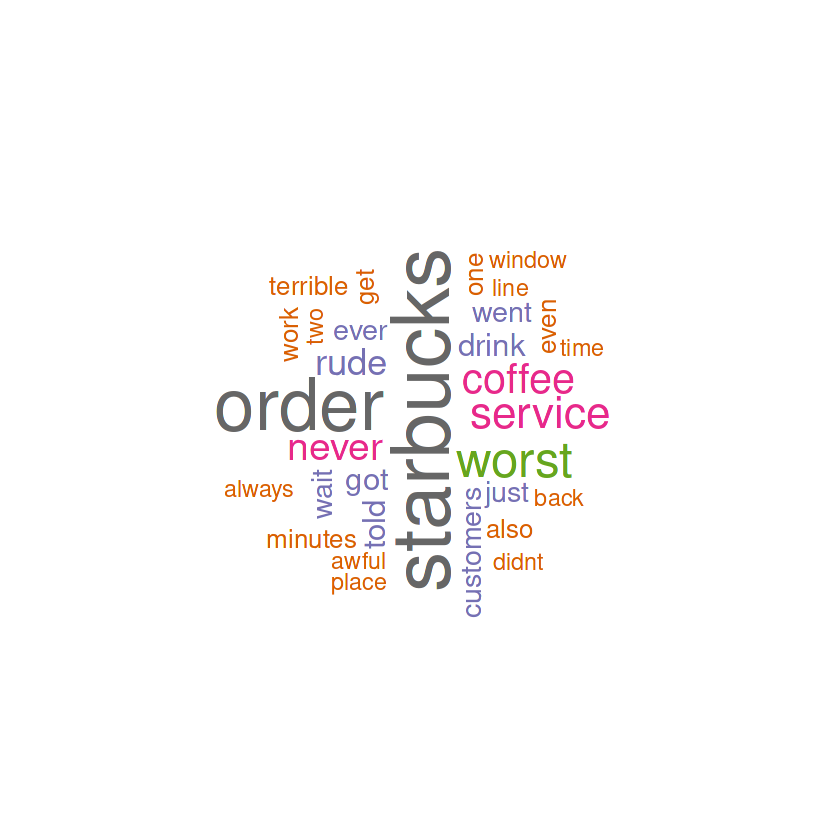

In [55]:
# Create a word cloud visualization
wordcloud(
  words = df$word,                # Words to display
  freq = df$freq,                 # Corresponding word frequencies
  min.freq = 5,                   # Only include words appearing at least 5 times
  max.words = 200,                # Limit the total number of words shown
  random.order = FALSE,           # Arrange words by frequency (not randomly)
  rot.per = 0.35,                 # Percentage of words rotated vertically
  colors = brewer.pal(8, "Dark2") # Use a color palette from RColorBrewer
)
